# Optimization Tutorial

Trey V. Wenger (c) January 2025

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.2+4.gfef408d.dirty


## Model Definition and Simulated Data

Like in the basic tutorial for `GaussNoiseModel`, our model is a Gaussian line profile with the spectral noise as a free parameter. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

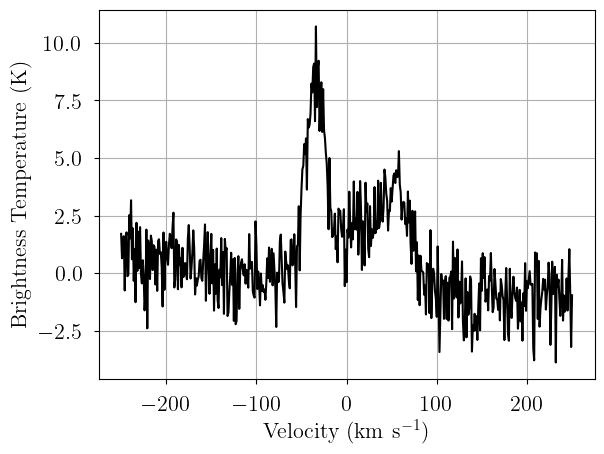

In [2]:
from bayes_spec import SpecData
from bayes_spec.models import GaussNoiseModel

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
noise = 1.0 # K
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "baseline_observation_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [3]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussNoiseModel,  # model definition
    data,  # data dictionary
    max_n_clouds=8,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC. The algorithm will stop early if two successive models fail to converge to a unique solution with an improving BIC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, kl_div_threshold=0.1, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.867e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2800
Interrupted at 2,799 [2%]: Average Loss = 1,051.6


Output()

n_cloud = 1 BIC = 1.954e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 977.64


Output()

n_cloud = 2 BIC = 1.584e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,024


Output()

n_cloud = 3 BIC = 1.567e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 7100
Interrupted at 7,099 [7%]: Average Loss = 1,006.1


Output()

n_cloud = 4 BIC = 1.591e+03

Stopping criteria met.
Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,065.1


Output()

n_cloud = 5 BIC = 1.611e+03

Stopping criteria met.
Stopping early.
Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,024
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],8.388,0.429,7.591,9.172,0.010,0.007,1702.0,2705.0,1.0
amplitude[1],3.679,0.570,2.644,4.672,0.017,0.012,1104.0,2092.0,1.0
amplitude[2],2.454,0.264,1.928,2.924,0.005,0.004,2512.0,2940.0,1.0
baseline_observation_norm[0],-0.666,0.073,-0.800,-0.529,0.001,0.001,2573.0,2602.0,1.0
baseline_observation_norm[1],-1.893,0.162,-2.186,-1.579,0.003,0.002,4009.0,2678.0,1.0
baseline_observation_norm[2],1.199,0.895,-0.525,2.821,0.016,0.012,3326.0,3063.0,1.0
fwhm[0],24.786,1.389,22.215,27.380,0.036,0.025,1524.0,2560.0,1.0
fwhm[1],34.274,4.675,25.420,42.966,0.130,0.092,1304.0,1722.0,1.0
fwhm[2],62.153,16.525,30.873,90.551,0.555,0.393,899.0,1355.0,1.0
fwhm_norm[0],0.826,0.046,0.741,0.913,0.001,0.001,1524.0,2560.0,1.0


With `approx=False`, the optimization algorithm samples each model with MCMC (or SMC if `smc=True`) and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower.

In [8]:
opt.optimize(bic_threshold=10.0, kl_div_threshold=0.1, sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 2.867e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2800
Interrupted at 2,799 [2%]: Average Loss = 1,051.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.952e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 977.64
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.581e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = 1,024
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.562e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7100
Interrupted at 7,099 [7%]: Average Loss = 1,006.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


Adding log-likelihood to trace


Output()

No solution found!
0 of 4 chains appear converged.

Stopping criteria met.
Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = 1,065.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_observation_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.

Stopping criteria met.
Stopping early.


Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging. Eventually the stopping criteria terminate the algorithm early.

In [9]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],8.388,0.429,7.591,9.172,0.010,0.007,1702.0,2705.0,1.0
amplitude[1],3.679,0.570,2.644,4.672,0.017,0.012,1104.0,2092.0,1.0
amplitude[2],2.454,0.264,1.928,2.924,0.005,0.004,2512.0,2940.0,1.0
baseline_observation_norm[0],-0.666,0.073,-0.800,-0.529,0.001,0.001,2573.0,2602.0,1.0
baseline_observation_norm[1],-1.893,0.162,-2.186,-1.579,0.003,0.002,4009.0,2678.0,1.0
baseline_observation_norm[2],1.199,0.895,-0.525,2.821,0.016,0.012,3326.0,3063.0,1.0
fwhm[0],24.786,1.389,22.215,27.380,0.036,0.025,1524.0,2560.0,1.0
fwhm[1],34.274,4.675,25.420,42.966,0.130,0.092,1304.0,1722.0,1.0
fwhm[2],62.153,16.525,30.873,90.551,0.555,0.393,899.0,1355.0,1.0
fwhm_norm[0],0.826,0.046,0.741,0.913,0.001,0.001,1524.0,2560.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [10]:
# leave-one-out cross validation
loo = az.compare({
    n_gauss: model.trace for n_gauss, model in opt.models.items()
    if model.solutions # ignore models with no valid solutions
})
loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-745.922040,10.327214,0.000000,1.000000e+00,14.527621,0.000000,False,log
2,1,-764.295616,9.409820,18.373576,1.249323e-10,14.224730,5.394648,False,log
1,2,-958.013450,7.627762,212.091410,0.000000e+00,21.799634,22.187274,False,log


The model with the largest `elpd_loo` is preferred.